In [1]:
import os
import cv2
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from scipy.misc import toimage
random.seed()

In [2]:
def jj(*args):
    return os.path.join(*args)

FACES = jj('data','faces')
OBJECTS = jj('data','objects')

FACES_GREY = jj('data','faces_grey')
OBJECTS_GREY = jj('data','objects_grey')

FACES_GREY_EQ = jj('data','faces_grey_eq')
OBJECTS_GREY_EQ = jj('data','objects_grey_eq')

FACES_EDGES = jj('data','faces_edges')
OBJECTS_EDGES = jj('data','objects_edges')

IMG_SIZE = 100
NUMBER_OF_FACES = 2000
NUMBER_OF_OBJECTS = 2000

In [3]:
def open_image(full_image_name):
    return cv2.imread(full_image_name, cv2.IMREAD_GRAYSCALE) #grey scale

def resize(img, n):
    return cv2.resize(img, (n, n))

def convert_to_array(img):
    return np.array(img, ndmin=3)

def resize_image_to_nxn_square(img, n):
    longer_side = max(img.shape)
    horizontal_padding = int((longer_side - img.shape[0]) / 2)
    vertical_padding = int((longer_side - img.shape[1]) / 2)
    
    new_image = cv2.copyMakeBorder(img,
                                   horizontal_padding,
                                   horizontal_padding,
                                   vertical_padding,
                                   vertical_padding,
                                   cv2.BORDER_CONSTANT)    
    resized_img = resize(new_image, n)
    return resized_img

def get_dataset():
    faces_list = []
    for img_name in tqdm(os.listdir(FACES)):
        path = jj(FACES, img_name)
        img = open_image(path)
        img = resize_image_to_nxn_square(img, IMG_SIZE)
#         cv2.imwrite(jj(FACES_GREY, img_name), img)
        
#         img = cv2.equalizeHist(img)
#         cv2.imwrite(jj(FACES_GREY_EQ, img_name), img)
        
        img = cv2.Canny(img, 120, 220) # Canny edge detection
#         cv2.imwrite(jj(FACES_EDGES, img_name), img)
        
        array = convert_to_array(img)
        faces_list.append(img)

    objects_list = []    
    for img_name in tqdm(os.listdir(OBJECTS)):
        path = jj(OBJECTS, img_name)
        img = open_image(path)
        img = resize_image_to_nxn_square(img, IMG_SIZE)
#         cv2.imwrite(jj(OBJECTS_GREY, img_name), img)
        
#         img = cv2.equalizeHist(img)
#         cv2.imwrite(jj(OBJECTS_GREY_EQ, img_name), img)
        
        img = cv2.Canny(img, 120, 220) # Canny edge detection
#         cv2.imwrite(jj(OBJECTS_EDGES, img_name), img)
        
        array = convert_to_array(img)
        objects_list.append(img)        

    random.shuffle(faces_list)
    random.shuffle(objects_list)
    
    faces_list = faces_list[:NUMBER_OF_FACES]
    objects_list = objects_list[:NUMBER_OF_OBJECTS]
        
    return faces_list + objects_list

In [5]:
dataset = get_dataset()
print(len(dataset))
print(dataset[0].shape)

100%|██████████████████████████████████| 16651/16651 [00:13<00:00, 1244.33it/s]


4000
(100, 100)


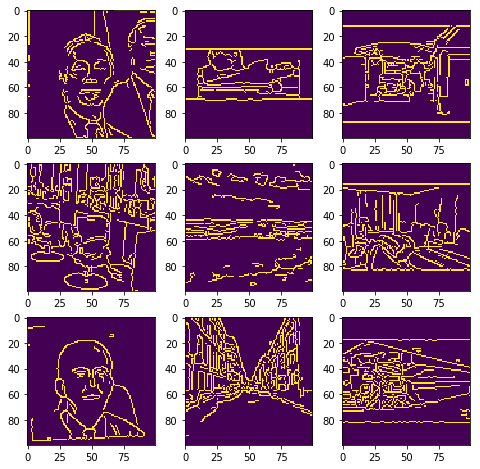

In [6]:
plt.clf()
plt.subplots(figsize=(8, 8))
for i in range(1, 10):
    random_number = random.choice(range(1, len(dataset)))
    plt.subplot(3,3,i)
    plt.imshow(toimage(dataset[random_number]))
plt.show()

In [7]:
labeled_dataset = [(array, 1 if num < NUMBER_OF_FACES else 0) for num, array in enumerate(dataset)]
random.shuffle(labeled_dataset)

In [8]:
train, validation = train_test_split(labeled_dataset, test_size = 0.25, random_state = 0)

x_train = np.asarray([i[0] for i in train])/255
y_train = np.asarray([i[1] for i in train])

x_validation = np.asarray([i[0] for i in validation])/255
y_validation = np.asarray([i[1] for i in validation])

In [9]:
x_train.shape

(3000, 100, 100)

In [10]:
x_train = np.reshape(x_train, (x_train.shape[0],IMG_SIZE*IMG_SIZE))
x_validation = np.reshape(x_validation, (x_validation.shape[0],IMG_SIZE*IMG_SIZE))


## MODEL EVALUATION

In [11]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = svm.SVC(C=1000000, gamma=0.000001)
model.fit(x_train, y_train) 

SVC(C=1000000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1e-06, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [12]:
# Skuteczność na zbiorze treningowym
y_pred = model.predict(x_train)
accuracy_score(y_train, y_pred)

1.0

In [13]:
# Skuteczność na zbiorze testowym
y_pred = model.predict(x_validation)
accuracy_score(y_validation, y_pred)

0.97599999999999998

In [14]:
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
# Skuteczność na zbiorze treningowym
y_pred = model.predict(x_train)
accuracy_score(y_train, y_pred)

1.0

In [18]:
# Skuteczność na zbiorze testowym
y_pred = model.predict(x_validation)
accuracy_score(y_validation, y_pred)

0.97199999999999998